In [1]:
import numpy as np
import operator

from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import LeNet

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.backends.backend_pdf
import matplotlib.cm as cm

import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE

import entropy_estimator

from sklearn import cluster
from sklearn import mixture
from sklearn.cluster import DBSCAN

import pandas as pd
import seaborn as sn

import interval_utils

import knockpy
from knockpy.knockoff_filter import KnockoffFilter

from pyitlib import discrete_random_variable as drv

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/minhvu/myroot/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
pred_to_label = {0: "No", 1:"Yes"}
animals = [2,3,4,5,6,7]
not_animals = [0,1,8,9]

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset.targets = torch.FloatTensor(trainset.targets)
# for target in not_animals:
#     trainset.targets[trainset.targets == target] = 0
# for target in animals:
#     trainset.targets[trainset.targets == target] = 1

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testset.targets = torch.FloatTensor(testset.targets)
# for target in not_animals:
#     testset.targets[testset.targets == target] = 0
# for target in animals:
#     testset.targets[testset.targets == target] = 1


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
SAVE_PATH = 'trained_model/cifar_animals_original.pth'
model = Net()
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [6]:
# Hook
main_layers = []
for item in model._modules.items():
    main_layers.append(item[0])
    
activation = {}
def get_activation(name):
    def hook(model, input, output_):
        activation[name] = output_.detach()
    return hook

def get_activations(model_, input_):
    for main_layer in main_layers:
        getattr(model, main_layer).register_forward_hook(get_activation(main_layer))
    activation = {}
    with torch.no_grad():
        model_output = model_(input_)
        
def dict_activation(model_, input_):
    get_activations(model_, input_)
    act_ = {}
    act_ = activation.copy()
#     act_['Input'] = input_.unsqueeze(0)
    return act_

In [7]:
def get_class_activation(model_, X_, y_, layers_):
    act_X = dict_activation(model_, X_)
    X_class = X.clone()
    acts_ = {}
    for layer_ in layers_:
        acts_[layer_] = act_X[str(layer_)].clone()  
    return X_class, acts_

In [8]:
probe_layers = ['fc1','fc2','fc3']

In [9]:
NUMBER_BATCH = 2000
    
for i, data in enumerate(testloader, 0):
    
    X, y = data

    if i == 0:
        X_, act_ = get_class_activation(model, X, y, probe_layers)
        y_ = y.clone()
    elif i < NUMBER_BATCH:
        X__, act__ = get_class_activation(model, X.to(DEVICE), y.to(DEVICE), probe_layers)
        X_ = torch.cat((X_, X__))
        y_ = torch.cat((y_, y.clone()))
        for layer in probe_layers:
            act_[layer] = torch.cat((act_[layer],act__[layer]))
    else:
        break

for layer in probe_layers:
    act_[layer] = act_[layer].reshape(act_[layer].shape[0],-1)

In [26]:
df_f1 = pd.DataFrame(data=np.array(act_['fc1'].cpu()))
df_f2 = pd.DataFrame(data=np.array(act_['fc2'].cpu()))
df_f3 = pd.DataFrame(data=np.array(act_['fc3'].cpu()))

df_f3['pred'] = np.where(df_f3[0] > df_f3[1], 0, 1)

df_all = [df_f1[df_f3['pred'] == 0], df_f2[df_f3['pred'] == 0], 
          df_f3[df_f3['pred'] == 0]]

In [32]:
number_of_agglo_feats = [8, 4]

top_neurons = {}

index_to_layer_name = dict(zip(range(len(number_of_agglo_feats)),
                              probe_layers[0:2]))

for frame_index in range(len(df_all)-1):

    X_var = np.array(df_all[frame_index])
    y_var = np.array(df_all[2])

    kfilter = KnockoffFilter(ksampler='gaussian', fstat='lasso')
    rejections = kfilter.forward(X=X_var, y=y_var[:,1], fdr=0.3)
    top_neurons[index_to_layer_name[frame_index]] = np.where(rejections==1)[0]

#     print(top_neurons[layer])
#     print(kfilter.W[top_neurons[layer]])
    print("Fraction of kept features: ", len(top_neurons[index_to_layer_name[frame_index]])/X_var.shape[1])

Fraction of kept features:  0.375
Fraction of kept features:  0.23809523809523808


In [33]:
df_all_ko = []
for frame_index in range(len(df_all)-1):
    df_all_ko.append(df_all[frame_index][top_neurons[probe_layers[frame_index]]])

df_all_ko_agglo = []
agglo_labels = []
for frame_index in range(len(number_of_agglo_feats)):
    agglo = cluster.FeatureAgglomeration(n_clusters=number_of_agglo_feats[frame_index])
    agglo.fit(df_all_ko[frame_index])
    df_all_ko_agglo.append(agglo.transform(df_all_ko[frame_index]))
    agglo_labels.append(agglo.labels_)

df_all_agglo = []
for frame_index in range(len(number_of_agglo_feats)):
    agglo = cluster.FeatureAgglomeration(n_clusters=number_of_agglo_feats[frame_index])
    agglo.fit(df_all[frame_index])
    df_all_agglo.append(agglo.transform(df_all[frame_index]))

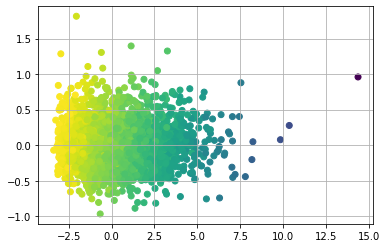

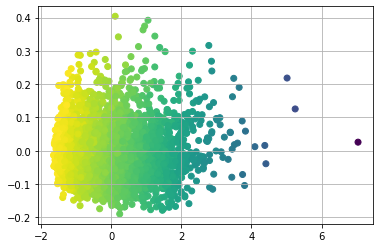

In [34]:
pca_all = PCA(n_components=2)

for frame_index in range(len(df_all)-1):
    plt.figure()
    df_array = np.array(df_all_agglo[frame_index])
    pca_all.fit(df_array)
    feat_mat_tf = pca_all.transform(df_array)
    plt.grid()
    plt.scatter(feat_mat_tf[:,0], feat_mat_tf[:,1], c=df_all[2][1])

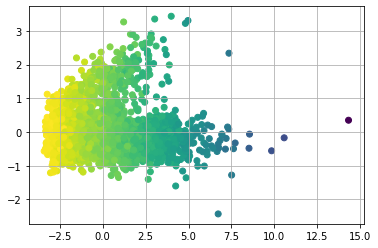

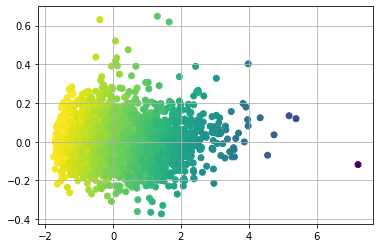

In [35]:
pca_all = PCA(n_components=2)

for frame_index in range(len(df_all)-1):
    plt.figure()
    df_array = np.array(df_all_ko_agglo[frame_index])
    pca_all.fit(df_array)
    feat_mat_tf = pca_all.transform(df_array)
    plt.grid()
    plt.scatter(feat_mat_tf[:,0], feat_mat_tf[:,1], c=df_all[2][1])

In [36]:
top_activations = {}
index_to_layer_name = dict(zip(range(len(number_of_agglo_feats)),
                              probe_layers[0:2]))
for frame_index in range(len(df_all)-1):
    X_var = np.array(df_all[frame_index])

    top_activations[index_to_layer_name[frame_index]] = np.sum(X_var,axis = 0).argsort()[-number_of_agglo_feats[frame_index]:][::-1]

# for layer in probe_layers:
#     if layer == 'classifier_2':
#         break
#     X_var = np.array(act_[layer].cpu())
#     top_activations[layer] = np.sum(X_var,axis = 0).argsort()[-number_of_agglo_feats[layer_name_to_index[layer]]:][::-1]

df_top_act = []
for frame_index in range(len(df_all)-1):
    df_top_act.append(df_all[frame_index][top_activations[probe_layers[frame_index]]])

In [37]:
# combine
no_k_component = 10

df_array_0 = np.array(df_all_ko_agglo[0])
df_array_1 = np.array(df_all_ko_agglo[1])
# df_array_2 = np.array(df_all_ko_agglo[2])

df_array = np.concatenate((df_array_0, df_array_1), axis=1)
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_ko_agglo_combine = gmm.predict(top_mat)

df_array_0 = np.array(df_top_act[0])
df_array_1 = np.array(df_top_act[1])
# df_array_2 = np.array(df_top_act[2])

df_array = np.concatenate((df_array_0, df_array_1), axis=1)
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_top_act_combine = gmm.predict(top_mat)

df_array_0 = np.array(df_all_agglo[0])
df_array_1 = np.array(df_all_agglo[1])
# df_array_2 = np.array(df_all_agglo[2])

df_array = np.concatenate((df_array_0, df_array_1), axis=1)
top_mat = df_array
gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
gmm.fit(top_mat)
gmm_label_all_agglo_combine = gmm.predict(top_mat)

In [38]:
digit_label = pd.DataFrame(data=np.array(y_.cpu()))[df_f3['pred'] == 0]

In [39]:
# score_act_combine = np.asarray([drv.entropy(np.array(y_[gmm_label_top_act_combine==c])) for c in range(no_k_component)])
# score_all_combine = np.asarray([drv.entropy(np.array(y_[gmm_label_all_agglo_combine==c])) for c in range(no_k_component)])
# score_ko_combine = np.asarray([drv.entropy(np.array(y_[gmm_label_ko_agglo_combine==c])) for c in range(no_k_component)])

score_act_combine =              np.asarray([drv.entropy(np.array(digit_label[gmm_label_top_act_combine==c][0])) for c in range(no_k_component)])
score_all_agglo_combine =        np.asarray([drv.entropy(np.array(digit_label[gmm_label_all_agglo_combine==c][0])) for c in range(no_k_component)])
score_ko_agglo_combine =         np.asarray([drv.entropy(np.array(digit_label[gmm_label_ko_agglo_combine==c][0])) for c in range(no_k_component)])


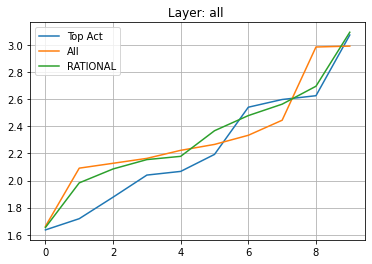

In [40]:
fig = plt.figure()

plt.plot(np.sort(score_act_combine))
plt.plot(np.sort(score_all_agglo_combine))
plt.plot(np.sort(score_ko_agglo_combine))

plt.grid()
plt.title("Layer: all ")
plt.legend(["Top Act", "All", "RATIONAL"])


In [41]:
no_runs = 100
k_low = 1
k_high = 10

range_component = k_high - k_low

act_scores = np.zeros((no_runs,range_component))
all_scores = np.zeros((no_runs,range_component))
rational_scores = np.zeros((no_runs,range_component))

for i in range(no_runs):
    print("Run: ", i+1)
    for no_component in range(range_component):
        no_k_component = no_component + k_low
        df_array_0 = np.array(df_all_ko_agglo[0])
        df_array_1 = np.array(df_all_ko_agglo[1])

        df_array = np.concatenate((df_array_0, df_array_1), axis=1)
        top_mat = df_array
        gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
        gmm.fit(top_mat)
        gmm_label_ko_agglo_combine = gmm.predict(top_mat)

        df_array_0 = np.array(df_top_act[0])
        df_array_1 = np.array(df_top_act[1])

        df_array = np.concatenate((df_array_0, df_array_1), axis=1)
        top_mat = df_array
        gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
        gmm.fit(top_mat)
        gmm_label_top_act_combine = gmm.predict(top_mat)

        df_array_0 = np.array(df_all_agglo[0])
        df_array_1 = np.array(df_all_agglo[1])

        df_array = np.concatenate((df_array_0, df_array_1), axis=1)
        top_mat = df_array
        gmm = mixture.GaussianMixture(n_components=no_k_component, covariance_type='full')
        gmm.fit(top_mat)
        gmm_label_all_agglo_combine = gmm.predict(top_mat)

        score_act_combine =       np.asarray([drv.entropy(np.array(digit_label[gmm_label_top_act_combine==c][0])) for c in range(no_k_component)])
        score_all_agglo_combine = np.asarray([drv.entropy(np.array(digit_label[gmm_label_all_agglo_combine==c][0])) for c in range(no_k_component)])
        score_ko_agglo_combine =  np.asarray([drv.entropy(np.array(digit_label[gmm_label_ko_agglo_combine==c][0])) for c in range(no_k_component)])

        act_scores[i,no_component] = np.average(score_act_combine)
        all_scores[i,no_component] = np.average(score_all_agglo_combine)
        rational_scores[i,no_component] = np.average(score_ko_agglo_combine)

Run:  1
Run:  2
Run:  3
Run:  4
Run:  5
Run:  6
Run:  7
Run:  8
Run:  9
Run:  10
Run:  11
Run:  12
Run:  13
Run:  14
Run:  15
Run:  16
Run:  17
Run:  18
Run:  19
Run:  20
Run:  21
Run:  22
Run:  23
Run:  24
Run:  25
Run:  26
Run:  27
Run:  28
Run:  29
Run:  30
Run:  31
Run:  32
Run:  33
Run:  34
Run:  35
Run:  36
Run:  37
Run:  38
Run:  39
Run:  40
Run:  41
Run:  42
Run:  43
Run:  44
Run:  45
Run:  46
Run:  47
Run:  48
Run:  49
Run:  50
Run:  51
Run:  52
Run:  53
Run:  54
Run:  55
Run:  56
Run:  57
Run:  58
Run:  59
Run:  60
Run:  61
Run:  62
Run:  63
Run:  64
Run:  65
Run:  66
Run:  67
Run:  68
Run:  69
Run:  70
Run:  71
Run:  72
Run:  73
Run:  74
Run:  75
Run:  76
Run:  77
Run:  78
Run:  79
Run:  80
Run:  81
Run:  82
Run:  83
Run:  84
Run:  85
Run:  86
Run:  87
Run:  88
Run:  89
Run:  90
Run:  91
Run:  92
Run:  93
Run:  94
Run:  95
Run:  96
Run:  97
Run:  98
Run:  99
Run:  100


In [42]:
ave_act_score = np.zeros(range_component)
ave_all_score = np.zeros(range_component)
ave_rational_score = np.zeros(range_component)
ci_act_score = np.zeros(range_component)
ci_all_score = np.zeros(range_component)
ci_rational_score = np.zeros(range_component)

for no_component in range(range_component):
    ave_act_score[no_component] = np.average(act_scores[:,no_component])
    ci_act_score[no_component] = 1.96 * np.std(act_scores[:,no_component])/np.mean(act_scores[:,no_component])
    ave_all_score[no_component] = np.average(all_scores[:,no_component])
    ci_all_score[no_component] = 1.96 * np.std(all_scores[:,no_component])/np.mean(all_scores[:,no_component])
    ave_rational_score[no_component] = np.average(rational_scores[:,no_component])
    ci_rational_score[no_component] = 1.96 * np.std(rational_scores[:,no_component])/np.mean(rational_scores[:,no_component])

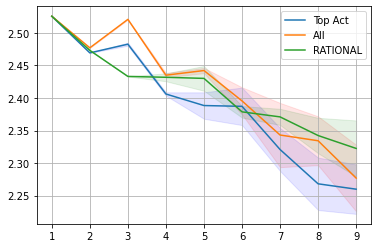

In [43]:
fig = plt.figure()

plt.grid()
plt.plot(range(k_low,k_high), ave_act_score)
plt.fill_between(range(k_low,k_high), (ave_act_score-ci_act_score), (ave_act_score+ci_act_score), color='b', alpha=.1)
plt.plot(range(k_low,k_high), ave_all_score)
plt.fill_between(range(k_low,k_high), (ave_all_score-ci_all_score), (ave_all_score+ci_all_score), color='r', alpha=.1)
plt.plot(range(k_low,k_high), ave_rational_score)
plt.fill_between(range(k_low,k_high), (ave_rational_score-ci_rational_score), (ave_rational_score+ci_rational_score), color='g', alpha=.1)


plt.legend(["Top Act", "All", "RATIONAL"])

In [48]:
ave_all_score

array([2.52560954, 2.47706855, 2.52081214, 2.43503937, 2.44217194,
       2.39550944, 2.34308315, 2.33427587, 2.27687911])

In [49]:
ci_all_score

array([3.44635557e-16, 3.51389086e-16, 3.02686048e-04, 3.42030570e-03,
       4.02320609e-03, 2.09224748e-02, 4.93716481e-02, 3.75492792e-02,
       5.11608170e-02])

In [46]:
ave_rational_score

array([2.52560954, 2.4731609 , 2.43314435, 2.43179624, 2.43010732,
       2.3786964 , 2.37093855, 2.34229595, 2.32245151])

In [47]:
ci_rational_score

array([3.44635557e-16, 7.03888575e-16, 2.15462800e-04, 6.09933029e-03,
       1.90086012e-02, 8.85996033e-03, 1.24322499e-02, 2.72202795e-02,
       4.30101048e-02])

In [51]:
drv.entropy([1,2,3,4])

array(2.)